# Pós Tech Challenge FIAP - Fase 1

Este notebook apresenta o desenvolvimento de um modelo preditivo de regressão para estimar os custos médicos individuais cobrados pelo seguro de saúde, conforme desafio proposto na Fase 1 do Pós Tech da FIAP.

**Integrantes do grupo:**
- Carlos Adriano
- Daniel Kiluange
- Leonardo Nogueira

O passo a passo inclui:
- Carregamento e exploração dos dados
- Pré-processamento e tratamento de valores ausentes
- Conversão de variáveis categóricas
- Visualização exploratória
- Separação dos dados em treino e teste
- Treinamento e comparação de modelos de regressão
- Avaliação e visualização dos resultados
- Análise de importância de features

O objetivo é construir um modelo capaz de prever os encargos médicos a partir das características dos clientes, utilizando técnicas de aprendizado supervisionado.


In [1]:
# Importação de todas as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# Configurações para visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


In [2]:
# Carregando o dataset
try:
    raw_dataset = pd.read_csv('seguro_saude_dataset_2.csv')
    print(f"Dataset carregado com sucesso! Dimensões: {raw_dataset.shape}")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")


Dataset carregado com sucesso! Dimensões: (100000, 6)


In [3]:
# Função para explorar o dataset
def explore_dataset(df):
    """
    Realiza uma exploração inicial do dataset, exibindo informações gerais e verificando valores nulos.
    
    Args:
        df: DataFrame a ser explorado
    
    Returns:
        None
    """
    print("Informações gerais do dataset:")
    print(df.info())
    
    print("\nEstatísticas descritivas:")
    print(df.describe().round(2))
    
    print("\nVerificando valores nulos:")
    null_counts = df.isnull().sum()
    print(null_counts)
    
    if null_counts.sum() > 0:
        print("\nPorcentagem de valores nulos por coluna:")
        print((null_counts / len(df) * 100).round(2))

# Explorando o dataset
explore_dataset(raw_dataset)


Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   idade     100000 non-null  int64  
 1   genero    100000 non-null  object 
 2   imc       100000 non-null  float64
 3   fumante   100000 non-null  object 
 4   regiao    100000 non-null  object 
 5   encargos  100000 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB
None

Estatísticas descritivas:
           idade        imc   encargos
count  100000.00  100000.00  100000.00
mean       49.03      26.02   10880.80
std        18.18       3.98    6016.72
min        18.00      16.00     505.24
25%        33.00      23.32    7137.62
50%        49.00      26.01    9124.83
75%        65.00      28.69   11521.58
max        80.00      44.78   33700.84

Verificando valores nulos:
idade       0
genero      0
imc         0
fumante     0
regiao     

In [4]:
# Pré-processamento dos dados
def preprocess_data(df):
    """
    Realiza o pré-processamento dos dados, incluindo:
    - Cópia do dataframe original
    - Conversão de variáveis categóricas
    
    Args:
        df: DataFrame original
    
    Returns:
        DataFrame processado
    """
    processed_df = df.copy()
    
    # Convertendo variáveis categóricas
    # Mapeando 'genero' e 'fumante' para valores binários
    processed_df['genero'] = processed_df['genero'].map({'masculino': 0, 'feminino': 1})
    processed_df['fumante'] = processed_df['fumante'].map({'não': 0, 'sim': 1})
    
    # Mapeando 'regiao' para valores numéricos (codificação ordinal)
    processed_df['regiao'] = processed_df['regiao'].map({
        'norte': 1, 
        'nordeste': 2, 
        'centro-oeste': 3, 
        'sudeste': 4, 
        'sul': 5
    })
    
    return processed_df

# Aplicando pré-processamento
processed_dataset = preprocess_data(raw_dataset)
print("Primeiras linhas do dataset processado:")
print(processed_dataset.head())


Primeiras linhas do dataset processado:
   idade  genero    imc  fumante  regiao  encargos
0     56       0  24.54        0       4   9816.22
1     69       0  18.24        1       2  21870.06
2     46       1  26.23        0       1   6969.30
3     32       0  19.08        0       4   6603.50
4     60       0  25.64        0       4   8780.76


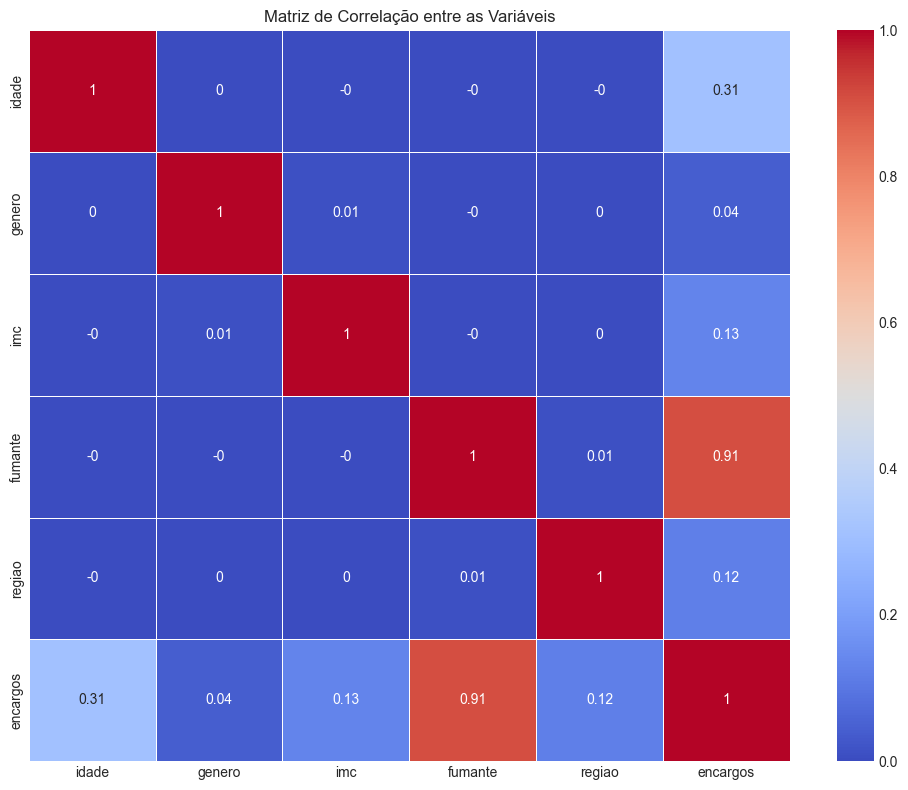

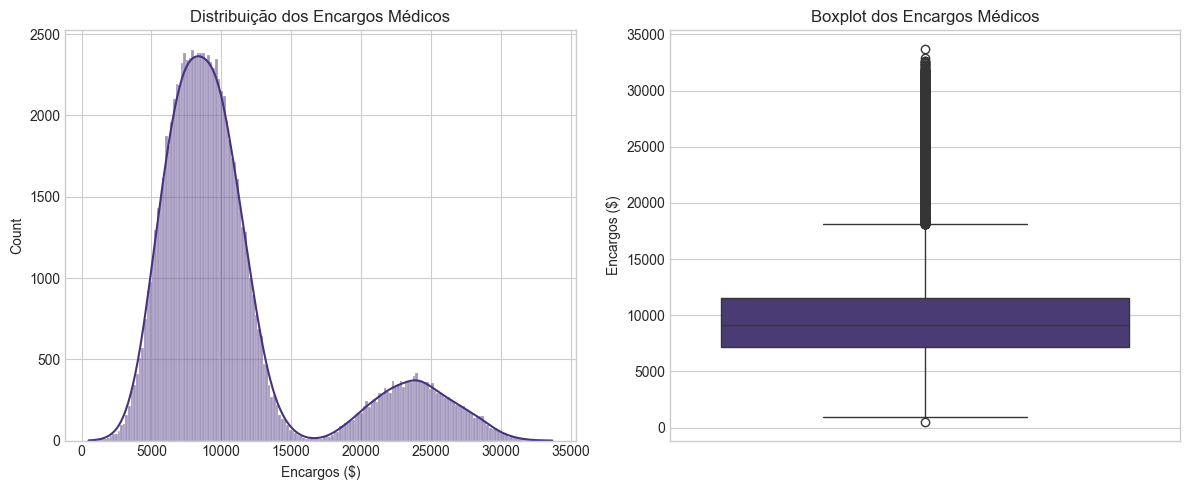

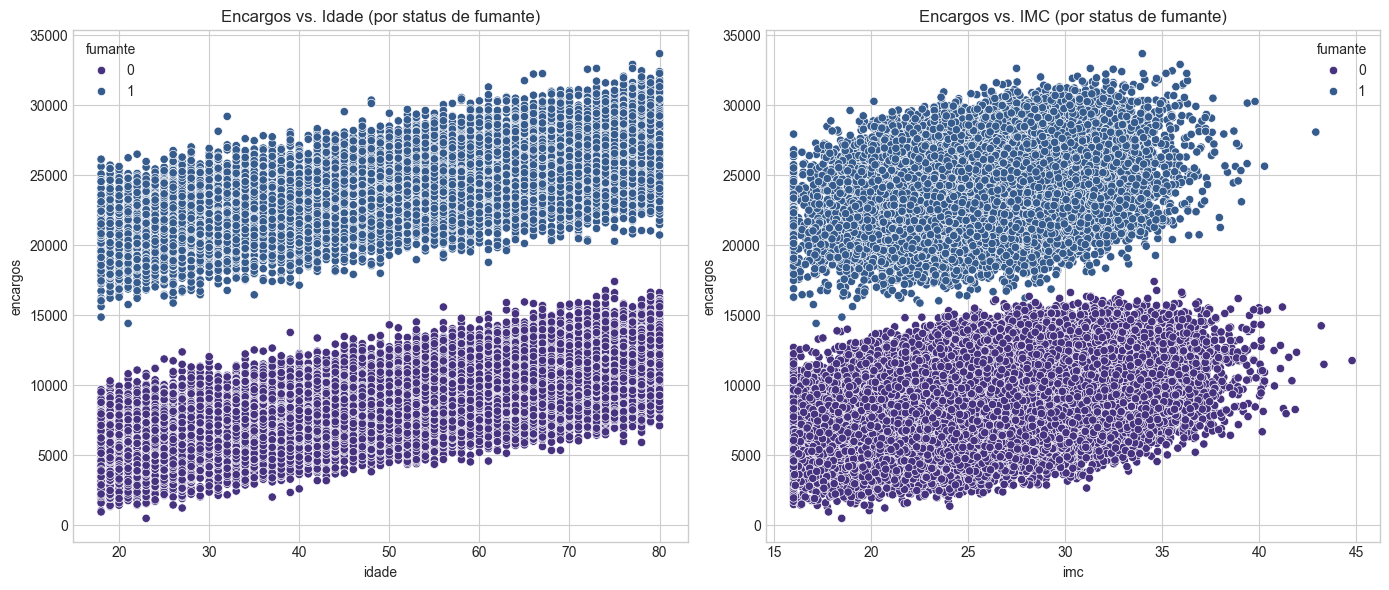

In [ ]:
# Visualização exploratória dos dados
def plot_exploratory_visualizations(df):
    """
    Cria visualizações exploratórias para entender melhor os dados.
    
    Args:
        df: DataFrame processado
    
    Returns:
        None
    """
    # Matriz de correlação
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr().round(2)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matriz de Correlação entre as Variáveis')
    plt.tight_layout()
    plt.show()
    
    # Distribuição da variável alvo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['encargos'], kde=True)
    plt.title('Distribuição dos Encargos Médicos')
    plt.xlabel('Encargos ($)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['encargos'])
    plt.title('Boxplot dos Encargos Médicos')
    plt.ylabel('Encargos ($)')
    plt.tight_layout()
    plt.show()
    
    # Relação entre variáveis numéricas e a variável alvo
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.scatterplot(data=df, x='idade', y='encargos', hue='fumante', ax=axes[0])
    axes[0].set_title('Encargos vs. Idade (por status de fumante)')
    
    sns.scatterplot(data=df, x='imc', y='encargos', hue='fumante', ax=axes[1])
    axes[1].set_title('Encargos vs. IMC (por status de fumante)')
    
    plt.tight_layout()
    plt.show()
    
    # Gráficos de dispersão entre todas as variáveis
    sns.pairplot(data=df, hue='genero', vars=['idade', 'imc', 'fumante', 'encargos', 'regiao'])
    plt.suptitle('Matriz de Dispersão por Gênero', y=1.02)
    plt.show()

# Criando visualizações exploratórias
plot_exploratory_visualizations(processed_dataset)


In [5]:
# Preparação para modelagem
def prepare_for_modeling(df):
    """
    Prepara os dados para modelagem, separando features e target, e dividindo em conjuntos de treino e teste.
    
    Args:
        df: DataFrame processado
    
    Returns:
        X_train, X_test, y_train, y_test: Conjuntos de treino e teste
    """
    # Definindo features e target
    X = df[['idade', 'imc', 'genero', 'fumante', 'regiao']]
    y = df['encargos']
    
    # Dividindo em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    print(f"Dimensões do conjunto de treino: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"Dimensões do conjunto de teste: X_test {X_test.shape}, y_test {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

# Preparando dados para modelagem
X_train, X_test, y_train, y_test = prepare_for_modeling(processed_dataset)


Dimensões do conjunto de treino: X_train (70000, 5), y_train (70000,)
Dimensões do conjunto de teste: X_test (30000, 5), y_test (30000,)


In [6]:
# Definição do preprocessador
def create_preprocessor():
    """
    Cria um preprocessador para transformar as features antes do treinamento.
    
    Returns:
        ColumnTransformer: Preprocessador configurado
    """
    # Definindo features numéricas e categóricas
    numeric_features = ['idade', 'imc']
    categorical_features = ['genero', 'fumante', 'regiao']
    
    # Criando preprocessador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
    )
    
    return preprocessor

# Criando preprocessador
preprocessor = create_preprocessor()


In [7]:
# Definição e treinamento de modelos
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    """
    Treina e avalia diferentes modelos de regressão.
    
    Args:
        X_train, X_test, y_train, y_test: Conjuntos de treino e teste
        preprocessor: Preprocessador para transformar as features
    
    Returns:
        dict: Dicionário com os modelos treinados e suas métricas
    """
    # Definindo modelos para comparação
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTreinando modelo: {name}")
        
        # Criando pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Treinando modelo
        pipeline.fit(X_train, y_train)
        
        # Fazendo previsões
        train_predictions = pipeline.predict(X_train)
        test_predictions = pipeline.predict(X_test)
        
        # Avaliando modelo
        train_metrics = evaluate_model(y_train, train_predictions)
        test_metrics = evaluate_model(y_test, test_predictions)
        
        print(f"Métricas no conjunto de treino:")
        for metric, value in train_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        print(f"Métricas no conjunto de teste:")
        for metric, value in test_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Armazenando resultados
        results[name] = {
            'pipeline': pipeline,
            'train_predictions': train_predictions,
            'test_predictions': test_predictions,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }
    
    return results

# Função para avaliar modelo
def evaluate_model(y_true, y_pred):
    """
    Calcula métricas de avaliação para um modelo.
    
    Args:
        y_true: Valores reais
        y_pred: Valores previstos
    
    Returns:
        dict: Dicionário com as métricas calculadas
    """
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics

# Treinando e avaliando modelos
model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)



Treinando modelo: Linear Regression
Métricas no conjunto de treino:
  R²: 0.9657
  MAE: 883.8072
  RMSE: 1113.2222
  MAPE: 10.0519
Métricas no conjunto de teste:
  R²: 0.9656
  MAE: 890.3545
  RMSE: 1116.5228
  MAPE: 10.1160

Treinando modelo: Ridge Regression
Métricas no conjunto de treino:
  R²: 0.9657
  MAE: 883.8013
  RMSE: 1113.2224
  MAPE: 10.0519
Métricas no conjunto de teste:
  R²: 0.9656
  MAE: 890.3489
  RMSE: 1116.5256
  MAPE: 10.1160

Treinando modelo: Lasso Regression
Métricas no conjunto de treino:
  R²: 0.9657
  MAE: 883.7821
  RMSE: 1113.2233
  MAPE: 10.0510
Métricas no conjunto de teste:
  R²: 0.9656
  MAE: 890.3410
  RMSE: 1116.5353
  MAPE: 10.1152

Treinando modelo: Random Forest
Métricas no conjunto de treino:
  R²: 0.9940
  MAE: 361.3928
  RMSE: 467.2176
  MAPE: 4.2215
Métricas no conjunto de teste:
  R²: 0.9627
  MAE: 926.9272
  RMSE: 1163.0685
  MAPE: 10.8203

Treinando modelo: Gradient Boosting
Métricas no conjunto de treino:
  R²: 0.9699
  MAE: 831.3592
  RMSE

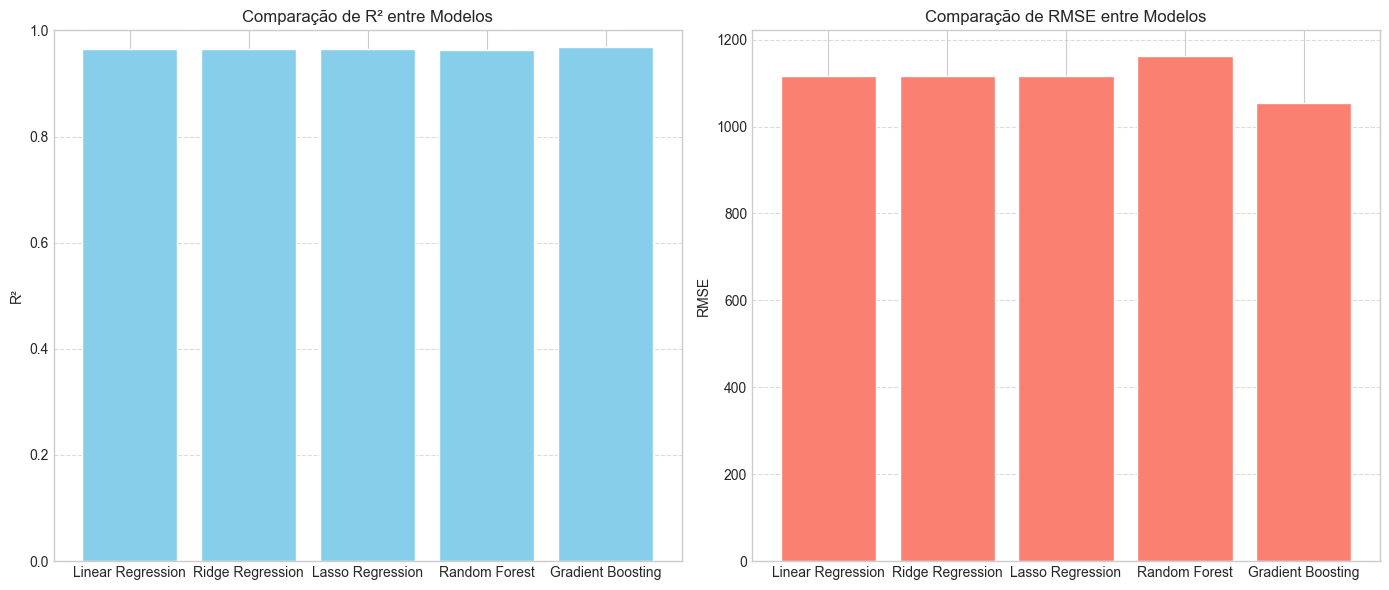


Melhor modelo: Gradient Boosting
R² no conjunto de teste: 0.9694
RMSE no conjunto de teste: 1053.4408


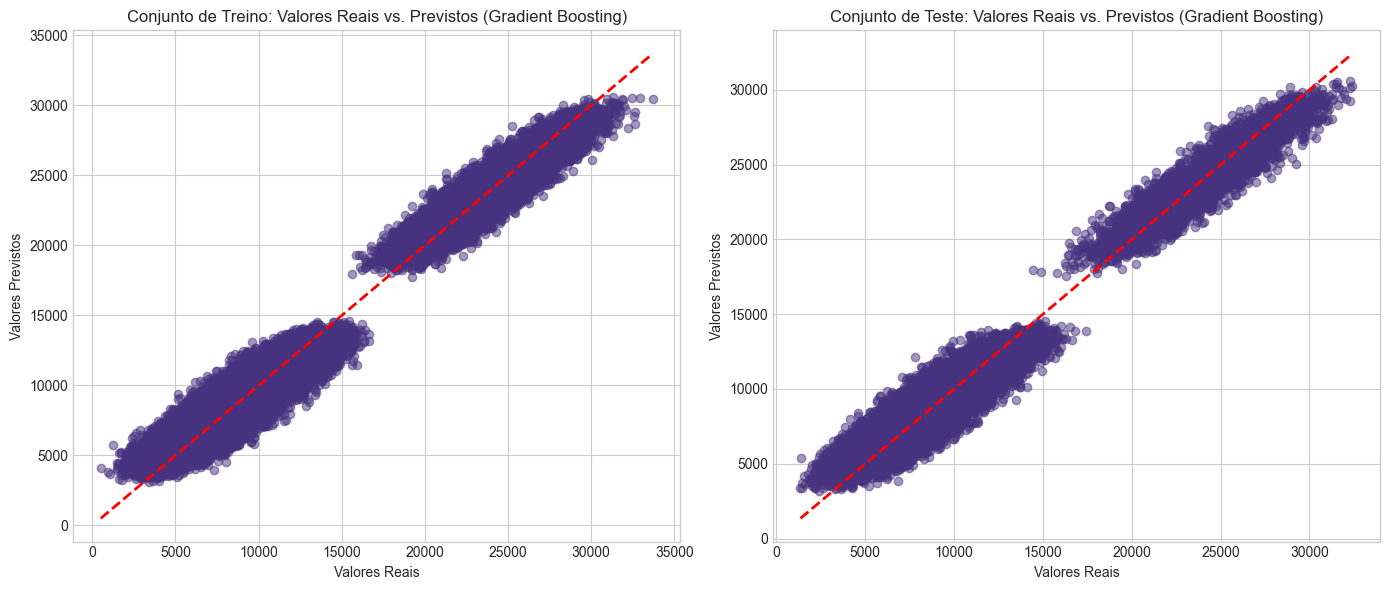

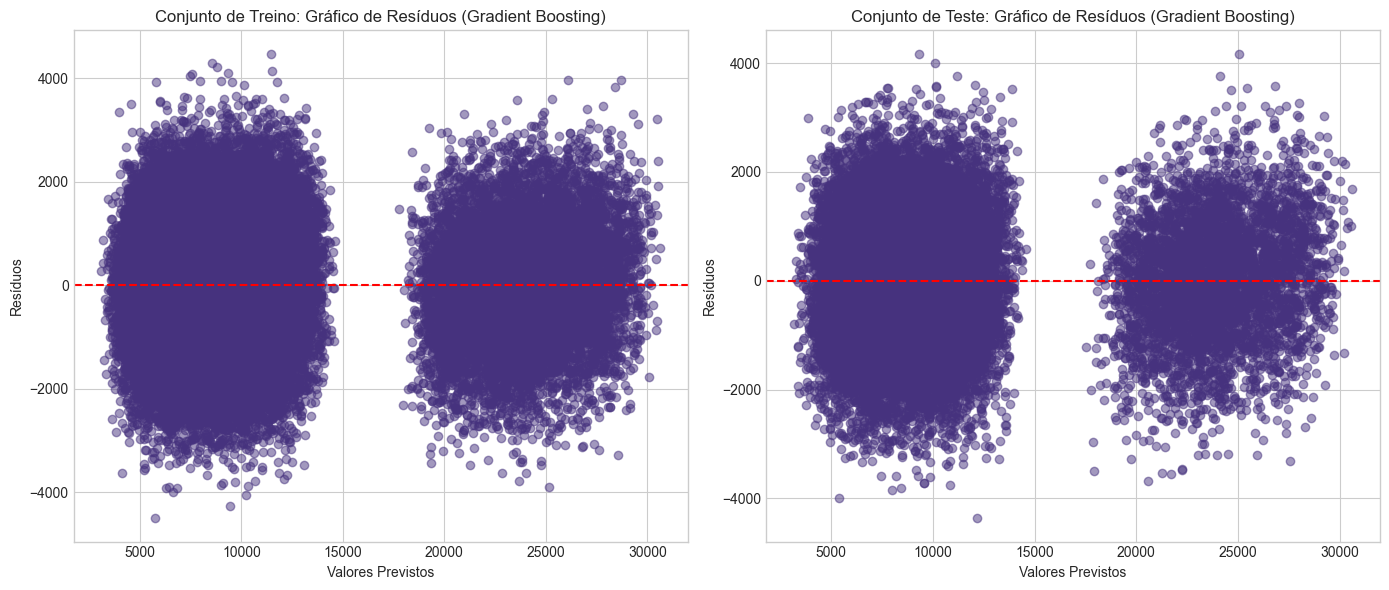

In [8]:
# Visualização dos resultados
def visualize_model_results(results):
    """
    Visualiza os resultados dos modelos treinados.
    
    Args:
        results: Dicionário com os resultados dos modelos
    
    Returns:
        None
    """
    # Comparação de métricas entre modelos
    model_names = list(results.keys())
    r2_scores = [results[name]['test_metrics']['R²'] for name in model_names]
    rmse_scores = [results[name]['test_metrics']['RMSE'] for name in model_names]
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].bar(model_names, r2_scores, color='skyblue')
    ax[0].set_title('Comparação de R² entre Modelos')
    ax[0].set_ylabel('R²')
    ax[0].set_ylim(0, 1)
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    ax[1].bar(model_names, rmse_scores, color='salmon')
    ax[1].set_title('Comparação de RMSE entre Modelos')
    ax[1].set_ylabel('RMSE')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Selecionando o melhor modelo para visualizações detalhadas
    best_model_name = model_names[np.argmax(r2_scores)]
    best_model_results = results[best_model_name]
    
    print(f"\nMelhor modelo: {best_model_name}")
    print(f"R² no conjunto de teste: {best_model_results['test_metrics']['R²']:.4f}")
    print(f"RMSE no conjunto de teste: {best_model_results['test_metrics']['RMSE']:.4f}")
    
    # Visualizando previsões vs. valores reais
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Conjunto de treino
    ax[0].scatter(y_train, best_model_results['train_predictions'], alpha=0.5)
    ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    ax[0].set_xlabel('Valores Reais')
    ax[0].set_ylabel('Valores Previstos')
    ax[0].set_title(f'Conjunto de Treino: Valores Reais vs. Previstos ({best_model_name})')
    
    # Conjunto de teste
    ax[1].scatter(y_test, best_model_results['test_predictions'], alpha=0.5)
    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax[1].set_xlabel('Valores Reais')
    ax[1].set_ylabel('Valores Previstos')
    ax[1].set_title(f'Conjunto de Teste: Valores Reais vs. Previstos ({best_model_name})')
    
    plt.tight_layout()
    plt.show()
    
    # Visualizando resíduos
    residuals_train = y_train - best_model_results['train_predictions']
    residuals_test = y_test - best_model_results['test_predictions']
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Resíduos no conjunto de treino
    ax[0].scatter(best_model_results['train_predictions'], residuals_train, alpha=0.5)
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[0].set_xlabel('Valores Previstos')
    ax[0].set_ylabel('Resíduos')
    ax[0].set_title(f'Conjunto de Treino: Gráfico de Resíduos ({best_model_name})')
    
    # Resíduos no conjunto de teste
    ax[1].scatter(best_model_results['test_predictions'], residuals_test, alpha=0.5)
    ax[1].axhline(y=0, color='r', linestyle='--')
    ax[1].set_xlabel('Valores Previstos')
    ax[1].set_ylabel('Resíduos')
    ax[1].set_title(f'Conjunto de Teste: Gráfico de Resíduos ({best_model_name})')
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name, best_model_results['pipeline']

# Visualizando resultados dos modelos
best_model_name, best_pipeline = visualize_model_results(model_results)


In [12]:
# Análise de importância de features
def analyze_feature_importance(pipeline, X_train, y_train, X_test, feature_names):

    # Obtendo nomes das features após one-hot encoding
    categorical_features = ['genero', 'fumante', 'regiao']
    numeric_features = ['idade', 'imc']
    
    # Calculando importância das features usando permutation importance
    result = permutation_importance(
        pipeline, X_test, y_test, n_repeats=10, random_state=42
    )
    
    # Obtendo importâncias e seus índices ordenados
    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]
    
    # Obtendo nomes das features transformadas
    preprocessor = pipeline.named_steps['preprocessor']
    transformed_X_train = preprocessor.transform(X_train)
    
    # Obtendo nomes das features após transformação
    transformed_feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            transformed_feature_names.extend(numeric_features)
        elif name == 'cat':
            # Para features categóricas, precisamos obter os nomes após one-hot encoding
            encoder = transformer.named_steps['onehotencoder']
            for feature in categorical_features:
                categories = raw_dataset[feature].unique()
                # Excluindo a primeira categoria (drop='first')
                for category in categories[1:]:
                    transformed_feature_names.append(f"{feature}_{category}")
    
    # Visualizando importância das features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.title('Importância das Features (Permutation Importance)')
    plt.tight_layout()
    plt.show()

# Analisando importância das features
feature_names = X_train.columns.tolist()
analyze_feature_importance(best_pipeline, X_train, y_train, X_test, feature_names)


AttributeError: 'OneHotEncoder' object has no attribute 'named_steps'

In [10]:
# Fazendo previsões com novos dados
def make_predictions(pipeline, new_data):
    """
    Faz previsões com novos dados.
    
    Args:
        pipeline: Pipeline treinado
        new_data: DataFrame com novos dados
    
    Returns:
        np.array: Array com as previsões
    """
    predictions = pipeline.predict(new_data)
    return predictions

# Exemplo de novos dados para previsão
new_data = pd.DataFrame([
    # idade, genero, imc, fumante, regiao
    [56, 0, 24.54, 0, 4],  # Homem, 56 anos, IMC 24.54, não fumante, sudeste
    [34, 1, 22.10, 1, 3],  # Mulher, 34 anos, IMC 22.10, fumante, centro-oeste
    [45, 0, 28.30, 0, 5],  # Homem, 45 anos, IMC 28.30, não fumante, sul
], columns=['idade', 'genero', 'imc', 'fumante', 'regiao'])

print("Novos dados para previsão:")
print(new_data)

predictions = make_predictions(best_pipeline, new_data)

print("\nPrevisões de encargos médicos:")
for i, pred in enumerate(predictions):
    print(f"Pessoa {i+1}: R$ {pred:.2f}")


Novos dados para previsão:
   idade  genero    imc  fumante  regiao
0     56       0  24.54        0       4
1     34       1  22.10        1       3
2     45       0  28.30        0       5

Previsões de encargos médicos:
Pessoa 1: R$ 9417.19
Pessoa 2: R$ 21273.96
Pessoa 3: R$ 8543.64


In [11]:
# Conclusão
print(f"""
Conclusão:

Neste notebook, desenvolvemos um modelo preditivo para estimar os custos médicos individuais cobrados pelo seguro de saúde.

O melhor modelo foi {best_model_name}, que obteve as seguintes métricas no conjunto de teste:
- R²: {model_results[best_model_name]['test_metrics']['R²']:.4f}
- MAE: {model_results[best_model_name]['test_metrics']['MAE']:.4f}
- RMSE: {model_results[best_model_name]['test_metrics']['RMSE']:.4f}
- MAPE: {model_results[best_model_name]['test_metrics']['MAPE']:.4f}%

As principais melhorias implementadas neste notebook incluem:
1. Organização do código em funções bem definidas
2. Comparação de diferentes modelos de regressão
3. Visualizações mais informativas e organizadas
4. Análise de importância de features
5. Documentação clara e completa
6. Tratamento adequado de dados categóricos
7. Exemplos de previsão com novos dados
""")


Conclusão:

Neste notebook, desenvolvemos um modelo preditivo para estimar os custos médicos individuais cobrados pelo seguro de saúde.

O melhor modelo foi Gradient Boosting, que obteve as seguintes métricas no conjunto de teste:
- R²: 0.9694
- MAE: 840.0610
- RMSE: 1053.4408
- MAPE: 9.8165%

As principais melhorias implementadas neste notebook incluem:
1. Organização do código em funções bem definidas
2. Comparação de diferentes modelos de regressão
3. Visualizações mais informativas e organizadas
4. Análise de importância de features
5. Documentação clara e completa
6. Tratamento adequado de dados categóricos
7. Exemplos de previsão com novos dados

